# Basic study on bitcoin returns

2 ways of obtaining stationary signal from returns:
- volatility standardized residual from a 7-days moving average
- volatility standardized log-returns

for each of these 2 stationary signals, we study seasonality and auto-correlation.

We do not obtain consistent results for auto-correlation:

- With the first signal, we observe correlation between consecutive returns
- For log-returns, no significant correlation is observed.

In [1]:
import ccxt
from pprint import pprint
okex = ccxt.okex()
candles = okex.fetch_ohlcv('BTC/USD', '1d', okex.parse8601('2017-01-08T00:00:00'))
#pprint([okex.iso8601(c[0]) for c in candles])

# I. Daily closing prices

In [2]:
import pandas as pd
btc = pd.DataFrame(candles, columns=['timestamp', 'open', 'highest', 'lowest', 'closing', 'volume'])#.set_index('timestamp')
# TODO normalize by USD price
btc.head()

btc = btc[['timestamp', 'closing']]
btc['dt'] = pd.to_datetime([okex.iso8601(c) for c in btc['timestamp']])
btc['day'] = btc['dt'].dt.dayofweek
btc['mva'] = btc['closing'].rolling(7, center=False).mean()
btc.head()

,timestamp,closing,dt,day,mva
0,1483848000000,912.02,2017-01-08 04:00:00,6,NaN
1,1483934400000,940.84,2017-01-09 04:00:00,0,NaN
2,1484020800000,942.82,2017-01-10 04:00:00,1,NaN
3,1484107200000,771.64,2017-01-11 04:00:00,2,NaN
4,1484193600000,769.96,2017-01-12 04:00:00,3,NaN


## I-A Log residual wrt 7-days mva

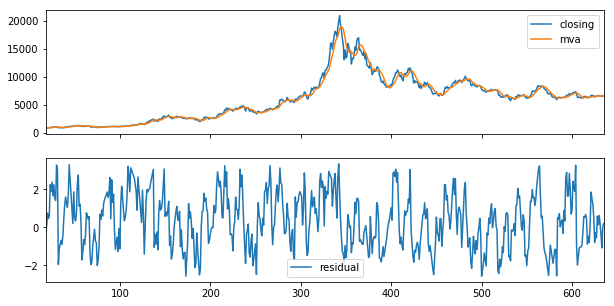

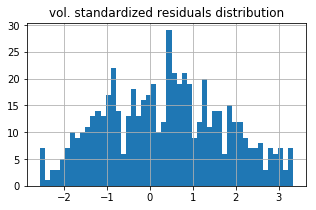

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# def log_plus_one(x):
#     return np.sign(x) * np.log(1 + np.abs(x))

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

btc[['dt', 'closing', 'mva']].plot(ax=ax[0])

btc['residual'] = btc['closing'] - btc['mva']

#btc['residual'] = btc['residual'].apply(log_plus_one) #np.sign(btc['closing'] - btc['mva']) * np.log(1 + np.abs(btc['closing'] - btc['mva']))
btc['residual'] /= btc['residual'].rolling(7).std()

# rm outliers:
btc = btc[abs(btc['residual'] - btc['residual'].mean()) < 2 * btc['residual'].std()]

btc[['dt', 'residual']].plot(ax=ax[1])

plt.show()


plt.figure(figsize=(5, 3))
plt.title('vol. standardized residuals distribution')
btc['residual'].hist(bins=50)
plt.show()

## Weekly seasonality ?
Let's try to see if there is weekly patterns, by looking at the average residual (price - 7_day_rolling_mva), volatility standardized:

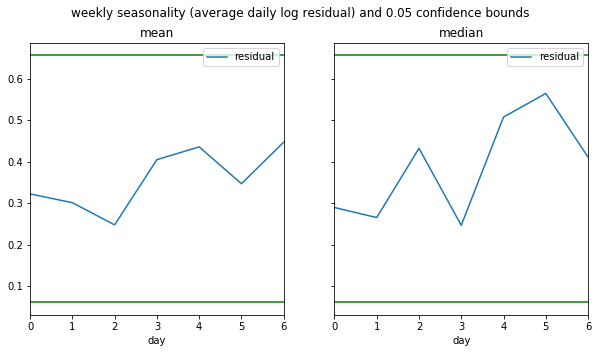

In [5]:
import itertools
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

btc[['day', 'residual']].groupby(['day']).mean().plot(ax=ax[0], title='mean')
btc[['day', 'residual']].groupby(['day']).median().plot(ax=ax[1], title='median')

conf_bound = 1.96 * btc['residual'].std() / np.sqrt(btc.shape[0] / 7.)

for i, s in itertools.product([0, 1], [-1, 1]):
    ax[i].hlines(btc['residual'].mean() + s*conf_bound, 0, 7, 'g')

plt.suptitle('weekly seasonality (average daily log residual) and 0.05 confidence bounds')
plt.show()

Monday=0, Sunday=6

Pattern is: 
- Lowest returns early in the week, highest returns late in the week.
- But not statistically significant.

## auto correlation

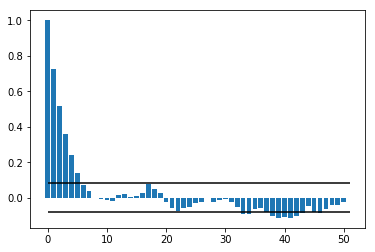

In [6]:

n = 51
autocorr = [btc['residual'].autocorr(lag=k) for k in range(n)]
plt.bar(range(len(autocorr)), autocorr)
plt.hlines(1.96 / np.sqrt(btc.shape[0]), 0, n)
plt.hlines(-1.96 / np.sqrt(btc.shape[0]), 0, n)

plt.show()

- postive correlation between consecutive daily returns
- negative correlation with days before 

-> trending + mean reverting ?

## I-B Daily log returns

same study with log returns (instead of deviation from the 7-days mva)

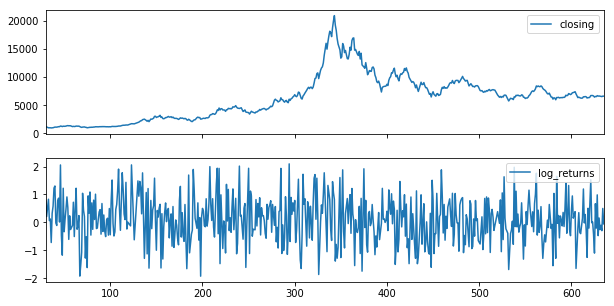

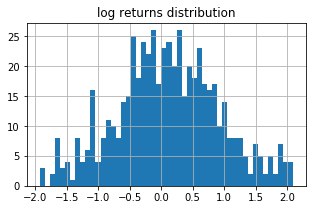

In [7]:
btc = pd.DataFrame(candles, columns=['timestamp', 'open', 'highest', 'lowest', 'closing', 'volume'])  # .set_index('timestamp')
btc = btc[['timestamp', 'closing']]
btc['dt'] = pd.to_datetime([okex.iso8601(c) for c in btc['timestamp']])
btc['day'] = btc['dt'].dt.dayofweek

btc['log_returns'] = np.log(btc['closing']) - np.log(btc['closing'].shift(1))
btc['log_returns'] /= btc['log_returns'].rolling(30).std()

# rm outliers:
btc = btc[abs(btc['log_returns'] - btc['log_returns'].mean()) < 2. * btc['log_returns'].std()]


fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

btc[['dt', 'closing']].plot(ax=ax[0])
btc[['dt', 'log_returns']].plot(ax=ax[1])

plt.show()

plt.figure(figsize=(5, 3))
plt.title('log returns distribution')
btc['log_returns'].hist(bins=50)
plt.show()

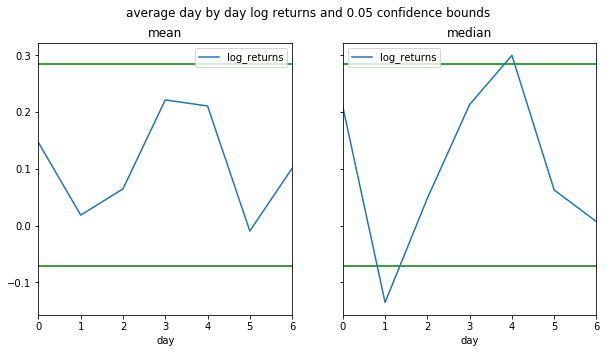

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

btc[['day', 'log_returns']].groupby(['day']).mean().plot(ax=ax[0], title='mean')
btc[['day', 'log_returns']].groupby(['day']).median().plot(ax=ax[1], title='median')

conf_bound = 1.96 * btc['log_returns'].std() / np.sqrt(btc.shape[0] / 7.)

for i, s in itertools.product([0, 1], [-1, 1]):
    ax[i].hlines(btc['log_returns'].mean() + s * conf_bound, 0, 7, 'g')

plt.suptitle('average day by day log returns and 0.05 confidence bounds')
plt.show()

Nothing is statistically significant except low returns on Tuesday according to the median estimate. 

Limitations:
- median=mean for normal distribution but the log returns do not look normal.
- multiple testing (7 tests) so we should increase confidence threshold

## Log returns auto-correlation

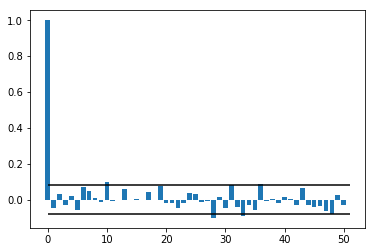

In [9]:

n = 51
autocorr = [btc['log_returns'].autocorr(lag=k) for k in range(n)]
plt.bar(range(len(autocorr)), autocorr)
plt.hlines(1.96 / np.sqrt(btc.shape[0]), 0, n)
plt.hlines(-1.96 / np.sqrt(btc.shape[0]), 0, n)

plt.show()

no significant correlation between consecutive log returns

# II. 5-minutes log returns

In [10]:
candles = okex.fetch_ohlcv('BTC/USD', '5m', okex.parse8601('2018-01-08T00:00:00'))

btc = pd.DataFrame(candles, columns=['timestamp', 'open', 'highest', 'lowest', 'closing', 'volume'])#.set_index('timestamp')
btc = btc[['timestamp', 'closing']]
btc['dt'] = pd.to_datetime([okex.iso8601(c) for c in btc['timestamp']])


# TODO normalize by USD price
btc['log_returns'] = np.log(btc['closing']) - np.log(btc['closing'].shift(1))
btc['log_returns'] /= btc['log_returns'].rolling(14).std()

# rm outliers:
btc = btc[btc['log_returns'] - btc['log_returns'].mean() < 2 * btc['log_returns'].std()]

btc['hour'] = btc['dt'].dt.hour

btc.head()

,timestamp,closing,dt,log_returns,hour
14,1538221500000,6562.50,2018-09-29 11:45:00,-0.385132,11
15,1538221800000,6575.84,2018-09-29 11:50:00,1.311782,11
16,1538222100000,6564.29,2018-09-29 11:55:00,-1.059091,11
17,1538222400000,6572.85,2018-09-29 12:00:00,0.816216,12
18,1538222700000,6557.24,2018-09-29 12:05:00,-1.341223,12


##  seasonality within the day:

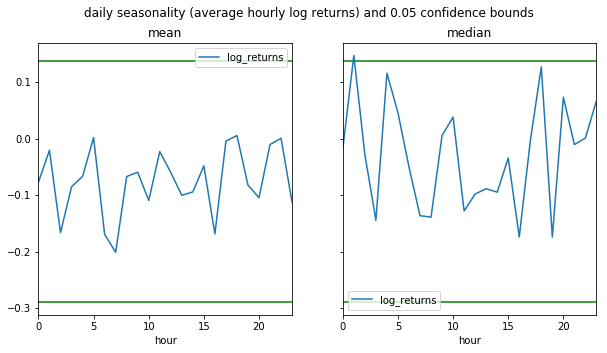

In [11]:
import itertools
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

btc[['hour', 'log_returns']].groupby(['hour']).mean().plot(ax=ax[0], title='mean')
btc[['hour', 'log_returns']].groupby(['hour']).median().plot(ax=ax[1], title='median')

conf_bound = 1.96 * btc['log_returns'].std() / np.sqrt(btc.shape[0] / 24.)
for i, s in itertools.product([0, 1], [-1, 1]):
    ax[i].hlines(btc['log_returns'].mean() + s * conf_bound, 0, 24, 'g') 

plt.suptitle('daily seasonality (average hourly log returns) and 0.05 confidence bounds')
plt.show()

no significant seasonality within the day

## auto correlation


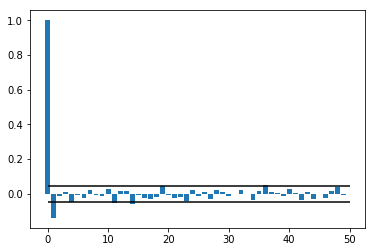

In [13]:
# minute log returns seem to be iid noise:

n = 50
autocorr = [btc['log_returns'].autocorr(lag=k) for k in range(n)]
plt.bar(range(len(autocorr)), autocorr)
plt.hlines(1.96 / np.sqrt(btc.shape[0]), 0, n)
plt.hlines(-1.96 / np.sqrt(btc.shape[0]), 0, n)

plt.show()

consecutive return seems negatively correlated (mean reversion microstructure?)
